In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.python.keras.models import Sequential
from tensorflow.python.keras.layers import Dense, Flatten
from tensorflow import keras

In [2]:
# Cargamos el dataset
dataset = pd.read_csv('wine.data', header=None,skiprows=1)
dataset.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13
0,1,14.23,1.71,2.43,15.6,127,2.80,3.06,0.28,2.29,5.64,1.04,3.92,1065
1,1,13.20,1.78,2.14,11.2,100,2.65,2.76,0.26,1.28,4.38,1.05,3.40,1050
2,1,13.16,2.36,2.67,18.6,101,2.80,3.24,0.30,2.81,5.68,1.03,3.17,1185
3,1,14.37,1.95,2.50,16.8,113,3.85,3.49,0.24,2.18,7.80,0.86,3.45,1480
4,1,13.24,2.59,2.87,21.0,118,2.80,2.69,0.39,1.82,4.32,1.04,2.93,735


In [3]:
#  Ahora vamos a separar los datos de entrenamiento y los datos de prueba
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(dataset.iloc[:, 1:], dataset.iloc[:, 0], test_size=0.35)

len(dataset),len(X_train),len(X_test)

(178, 115, 63)

In [4]:
# Normalizamos nuestros conjuntos de datos
# X_train_mean = X_train.mean()   
# X_train_std = X_train.std()
# X_train = (X_train - X_train_mean) / X_train_std

# X_test_mean = X_test.mean()
# X_test_std = X_test.std()
# X_test = (X_test - X_test_mean) / X_test_std

X_train = X_train/X_train.max()
X_test = X_test/X_test.max()



In [5]:
y_train.head()

54     1
174    3
38     1
51     1
16     1
Name: 0, dtype: int64

In [6]:
X_train.head()

,1,2,3,4,5,6,7,8,9,10,11,12,13
54,0.926500,0.287931,0.696594,0.546667,0.848921,0.670103,0.570866,0.333333,0.452514,0.450000,0.538012,0.8000,0.630952
174,0.903574,0.674138,0.767802,0.766667,0.733813,0.463918,0.147638,0.682540,0.393855,0.561538,0.409357,0.3900,0.446429
38,0.881322,0.258621,0.650155,0.516667,0.705036,0.618557,0.519685,0.444444,0.382682,0.284615,0.690058,0.6725,0.607143
51,0.932569,0.284483,0.804954,0.573333,0.676259,0.631443,0.588583,0.349206,0.639665,0.430769,0.725146,0.8425,0.752976
16,0.964262,0.331034,0.842105,0.666667,0.863309,0.721649,0.618110,0.523810,0.550279,0.476923,0.625731,0.6625,0.761905


In [7]:
# X_train = np.array(X_train)
# y_train = np.array(y_train)

In [48]:
from tensorflow.python.keras.layers import Input, Dense, Activation, Flatten
from tensorflow.python.keras.layers import Dropout
from tensorflow.python.keras.models import Model

from tensorboard.plugins.hparams import api as hp

In [49]:
import tensorflow as tf

In [70]:
HP_NUM_UNITS = hp.HParam('num_units', hp.Discrete([16, 32]))
HP_DROPOUT = hp.HParam('dropout', hp.Discrete([0.1, 0.4]))
HP_OPTIMIZER = hp.HParam('optimizer', hp.Discrete(['adam', 'sgd']))
HP_LEARNINGRATE= hp.HParam('learning_rate', hp.Discrete([0.1,0.01,0.001]))

METRIC_ACCURACY = 'accuracy'

with tf.summary.create_file_writer('logs/hparam_tuning').as_default():
  hp.hparams_config(
    hparams=[HP_NUM_UNITS, HP_DROPOUT, HP_OPTIMIZER, HP_LEARNINGRATE],
    metrics=[hp.Metric(METRIC_ACCURACY, display_name='Accuracy')],
  )

def architecture(input_shape, num_classes, p_drop, units, dropout=True):
    
    # Defining the input as a tensor with shape input_shape. 
    InputLayer = Input(input_shape)
    
    # Defining the first hidden layer with 50 nodes and sigmoid as activation function
    x = Dense(64, kernel_initializer='random_uniform', bias_initializer='zeros', name='hl_1')(InputLayer)
    x = Activation('relu')(x)
    if dropout == True:
        x = Dropout(p_drop)(x)

    x = Dense(128, kernel_initializer='random_uniform', bias_initializer='zeros', name='hl_2')(x)
    x = Activation('sigmoid')(x)
    if dropout == True:
        x = Dropout(p_drop)(x)
    
    
    # For the output layer we use the activation function 'softmax')
    x = Dense(1, kernel_initializer='random_uniform', bias_initializer='zeros')(x)
    OutputLayer = Activation('softmax', name='output-layer')(x)
    
    # This creates the Keras model instance, you'll use this instance to train/test the model.
    model = Model(inputs = InputLayer, outputs = OutputLayer, name='Cifar10Model')

    return model


In [71]:
num_classes=3

def train_test_model(hparams):

    model = architecture(input_shape=(13,), num_classes=num_classes, 
                       p_drop=hparams[HP_DROPOUT], units=hparams[HP_NUM_UNITS])
    model.compile(
          optimizer=hparams[HP_OPTIMIZER],
          loss='categorical_crossentropy',
          metrics=['accuracy']
      )
    model.optimizer.learning_rate=hparams[HP_LEARNINGRATE]
    model.fit(X_train, y_train, epochs = 1, batch_size = 32, \
                                validation_split = 0.01, shuffle=True, verbose=0) # Run with 1 epoch to speed things up for demo purposes
    evaluations = model.evaluate(x = X_test, y = y_test)
    accuracy = evaluations[1]
    
    return accuracy

def training(run_dir, hparams):
    with tf.summary.create_file_writer(run_dir).as_default():
        hp.hparams(hparams)  # record the values used in this trial
        accuracy = train_test_model(hparams)
        tf.summary.scalar(METRIC_ACCURACY, accuracy, step=1)

from collections import OrderedDict, namedtuple
from itertools import product
session_num = 0

class RunBuilder():
    @staticmethod
    def get_runs(params):
        Run=namedtuple('Run', params.keys())

        runs=[]

        for v in product(*params.values()):
            runs.append(Run(*v))

        return runs
    
params=OrderedDict(
        num_units=[num_units for num_units in HP_NUM_UNITS.domain.values],
        p_drop=[dropout_rate for dropout_rate in (HP_DROPOUT.domain.values)],
        optim=[optimizer for optimizer in HP_OPTIMIZER.domain.values],
        lr=[lr for lr in HP_LEARNINGRATE.domain.values],
    )

for run in RunBuilder().get_runs(params):
    hparams = {
          HP_NUM_UNITS: run.num_units,
          HP_DROPOUT: run.p_drop,
          HP_OPTIMIZER: run.optim,
          HP_LEARNINGRATE: run.lr
      }
    run_name = "run-%d" % session_num
    print('--- Starting trial: %s' % run_name)
    print({h.name: hparams[h] for h in hparams})
    training('logs/hparam_tuning/' + run_name, hparams)
    session_num += 1

--- Starting trial: run-0
{'num_units': 16, 'dropout': 0.1, 'optimizer': 'adam', 'learning_rate': 0.001}
2/2 [==============================] - 0s 3ms/step - loss: 0.0000e+00 - accuracy: 0.3175
--- Starting trial: run-1
{'num_units': 16, 'dropout': 0.1, 'optimizer': 'adam', 'learning_rate': 0.01}
2/2 [==============================] - 0s 3ms/step - loss: 0.0000e+00 - accuracy: 0.3175
--- Starting trial: run-2
{'num_units': 16, 'dropout': 0.1, 'optimizer': 'adam', 'learning_rate': 0.1}
2/2 [==============================] - 0s 3ms/step - loss: 0.0000e+00 - accuracy: 0.3175
--- Starting trial: run-3
{'num_units': 16, 'dropout': 0.1, 'optimizer': 'sgd', 'learning_rate': 0.001}
2/2 [==============================] - 0s 3ms/step - loss: 0.0000e+00 - accuracy: 0.3175
--- Starting trial: run-4
{'num_units': 16, 'dropout': 0.1, 'optimizer': 'sgd', 'learning_rate': 0.01}
2/2 [==============================] - 0s 3ms/step - loss: 0.0000e+00 - accuracy: 0.3175
--- Starting trial: run-5
{'num_unit

Nuevo modelo

In [8]:
len(X_train),len(y_train)

(115, 115)

In [46]:
model = Sequential([
    Dense(3, input_shape=(13,), activation="relu"),
    Dense(16, activation="tanh"),
    Dense(32, activation="relu"),
    Dense(1, activation="softmax")
])
model.build(input_shape=(None, 13))

# Probaremos varios optimizadores
# model.compile(optimizer=("sgd", "rmsprop", "adagrad", "adadelta", "adam", "adamax", "nadam"),
# from tensorflow.python.keras.optimizers import adam
model.compile(optimizer="rmsprop",
              loss="categorical_crossentropy",
              metrics=["accuracy"])

history_small_model=model.fit(X_train, y_train, epochs=100, batch_size=8, validation_split=0.01, verbose=1)

Epoch 1/100
15/15 [==============================] - 1s 12ms/step - loss: 0.0000e+00 - accuracy: 0.3363 - val_loss: 0.0000e+00 - val_accuracy: 0.5000
Epoch 2/100
15/15 [==============================] - 0s 3ms/step - loss: 0.0000e+00 - accuracy: 0.3363 - val_loss: 0.0000e+00 - val_accuracy: 0.5000
Epoch 3/100
15/15 [==============================] - 0s 3ms/step - loss: 0.0000e+00 - accuracy: 0.3363 - val_loss: 0.0000e+00 - val_accuracy: 0.5000
Epoch 4/100
15/15 [==============================] - 0s 3ms/step - loss: 0.0000e+00 - accuracy: 0.3363 - val_loss: 0.0000e+00 - val_accuracy: 0.5000
Epoch 5/100
15/15 [==============================] - 0s 3ms/step - loss: 0.0000e+00 - accuracy: 0.3363 - val_loss: 0.0000e+00 - val_accuracy: 0.5000
Epoch 6/100
15/15 [==============================] - 0s 3ms/step - loss: 0.0000e+00 - accuracy: 0.3363 - val_loss: 0.0000e+00 - val_accuracy: 0.5000
Epoch 7/100
15/15 [==============================] - 0s 3ms/step - loss: 0.0000e+00 - accuracy: 0.3363 - 

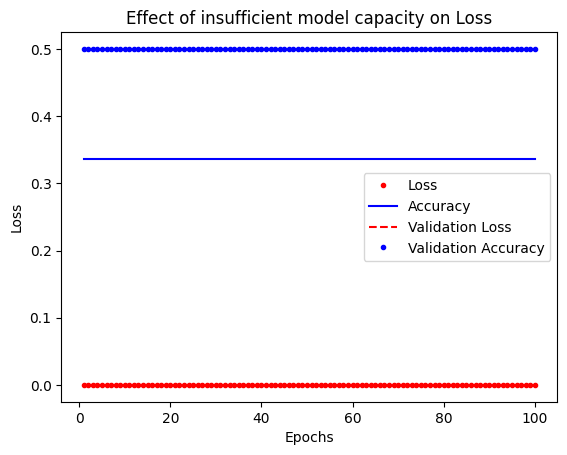

In [47]:
loss = history_small_model.history["loss"]
epochs = range(1, 101)
acc = history_small_model.history["accuracy"]

plt.plot(epochs, loss, "r.",label="Loss")
plt.plot(epochs,acc, "b",label="Accuracy")
plt.plot(epochs, history_small_model.history["val_loss"], "r--",label="Validation Loss")
plt.plot(epochs, history_small_model.history["val_accuracy"], "b.",label="Validation Accuracy")
plt.title("Effect of insufficient model capacity on Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()